In [1]:
import xarray as xr
import matplotlib.dates as mdates
import numpy as np
import matplotlib
from matplotlib import rcParams
import datetime
import pandas as pd
import cftime
import pylab as plt
import netCDF4 as nc
from numpy import ma
import dask as dd
from matplotlib.colors import LinearSegmentedColormap,ListedColormap
from matplotlib import cm
from eofs.standard import Eof
import xeofs as xf

## Map Plotting imports

from matplotlib.colors import LinearSegmentedColormap,ListedColormap
from matplotlib import cm
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

#stash codes
stash_ch4 = 'mass_fraction_of_methane_in_air'
stash_co = 'mass_fraction_of_carbon_monoxide_in_air'
stash_ch4_oh = 'm01s50i041'
stash_oh = 'mass_fraction_of_hydroxyl_radical_in_air'
stash_o3 = 'mass_fraction_of_ozone_in_air'
stash_trop = 'm01s50i062'
stash_mass = 'm01s50i063'
stash_temp = 'surface_temperature'
stash_nox = 'm01s50i081'

#define functions
def molec_cm3(conc_kg_kg, mass, vol, mr):
    molec_box = conc_kg_kg*mass/mr*1000*n_a #molecules per box
    cm3 = molec_box/(vol*1e6) #molec per cm3
    return cm3

def moving_average(x, months):
    return np.convolve(x, np.ones(months), 'valid') / months

def full_average(x, months):
    return np.convolve(x, np.ones(months), 'same') / months

#define constants
n_a = 6.02e23
oh_mr = 17

In [2]:
# Area and volume datasets

area = nc.Dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/areacella_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc')
box_area = area.variables['areacella'][:]

total_area = np.sum(box_area)
area_scaled = box_area/total_area
lat_area_scaled = area_scaled[:,0]#1D array of latitude scaling values

In [3]:
# Altitude data to obtain volumes

data_alt = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/vol_n96.nc')
vol = data_alt.grid_cell_volume
vol = vol.data

In [4]:
#### Fetch data
oh_data_949 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/ubl949_oh_apm_1960_2340_PI.nc',chunks={'time':25})

airmass_data_949 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/ubl949_airmass_PI.nc',chunks={'time':24})
airmass_949 = airmass_data_949[stash_mass][:]
av_airm = np.mean(airmass_949,axis=0)

oh_949 = oh_data_949[stash_oh].astype('float64')[:]
# repeating last data point allows data to be averaged into 12 sample slices with a negligible effect on the weighting of datapoints
oh_949 = xr.concat((oh_949,oh_949[-1,:,:]),dim='time')

lat = oh_data_949.latitude[:]
lon = oh_data_949.longitude[:]
time = oh_data_949.time[:]
dtime = nc.date2num(time,'days since 2000-01-01 00:00:00',calendar='360_day',has_year_zero=True)

# Convert to molec cm3 concentration
oh_conc = molec_cm3(oh_949,av_airm,vol,oh_mr)

# Select altitudes well within troposphere, take from surface as methane is not prescribed in this model, take a max altitude as 300hPa / 9160.1m
oh_conc['model_level_number'] = oh_conc.level_height
oh_conc = oh_conc.loc[:,1948.2:9160.1,-25:25,:]

In [5]:
# deseasonalization function

# define troposperic mean to use in trend calculations, doing this now makes everything more simple
# Also attempting to use an airmass weighted average greatly increases the memory load here, so it has been omitted for now as its not particularly relevant, especially when
# doing the computation on only lower altitudes anyway 
oh_loop = np.mean(oh_conc,axis=1)

# Run deseasonalisation twice to improve the estimate of the trend
for i in range(2):
    # 1:Determine overall data trend from yearly means and create smoothed curve using interpolation on the yearly means
    trend = oh_loop.coarsen(time=12).mean()
    meantrend = trend.interp(time=oh_loop.time,method='linear',kwargs={'fill_value':'extrapolate'})

    # 2:Subtract meantrend from the input data to detrend the data
    detrend = oh_loop - meantrend

    # 3:Calculate monthly means from the detrended data to give the stable seasonal filtered data
    stable_season = detrend.groupby('time.month').mean('time')# - detrend.groupby('time.month').mean('time')

    # 4:Deseasonalize the time series data by subtracting stable seasonal filter
    oh_loop = oh_loop.groupby('time.month') - stable_season

# rechunk
oh_out = oh_loop.drop_duplicates(dim='time')
oh_out = oh_out.chunk('auto')

In [6]:
# Center the data ready for eof analysis

# trend = oh_out.coarsen(time=12).mean()
# meantrend = trend.interp(time=oh_out.time,method='linear',kwargs={'fill_value':'extrapolate'})
# oh_detrend = oh_out - meantrend

meanlatlon = np.mean(oh_out,axis=0)
meanlatlon = meanlatlon.expand_dims({'time':4571}) # don't need to expand dims as array will just be subtracted from every element anyway
oh_anom = np.multiply(np.divide(oh_out - meanlatlon,meanlatlon),100)
oh_anom_gm = np.mean(oh_anom,axis=(1,2))

In [7]:
oh_anom = oh_anom.compute()

In [8]:
## This works, but takes ages to run so don't bother unless you really want it
# # Plot deseasonalised data to check
# fig = plt.figure(dpi=300)
# ax = plt.axes()

# ax.plot(time,oh_anom_gm,linewidth=0.1,label='unsmoothed')
# # p1 = ax.fill_between(dtime, oh_anom, 0 ,where=(oh_anom > 0), facecolor='red', alpha=0.5, label = 'Positive anomaly')
# # p2 = ax.fill_between(dtime, oh_anom, 0 ,where=(oh_anom < 0), facecolor='blue', alpha=0.5, label = 'Negative anomaly')

# plt.title('Plot of deseasonalised [OH] in the troposphere')
# ax.set_ylabel('OH anomaly / % ')
# ax.set_xlabel('time / yr')

# ax.set_xlim(dtime_949[0],dtime_949[1200])

# plt.savefig('Smoothing_test.png',dpi=300)

In [9]:
# Create eofs for seasonal monthly data
# define weights then create a grid of scaled values with sqrt(cos(latitude))
weight_lat = np.sqrt(np.abs(np.cos(np.deg2rad(oh_anom.latitude))))
weight_grid_lonlat = np.tile(weight_lat,(192,1))
w_use = weight_grid_lonlat.transpose()

# for some reason doesn't like to do the analysis on the dask array, gives an error about missing values and wrong size matrices, but computing into a numpy array works fine
# oh_comp = np.array(oh_anom.compute())

# eof analysis
# des_eofs = Eof(oh_comp,weights=w_use,center=False)
des_eofs = xf.xarray.eof.EOF(oh_anom,dim=['time'],n_modes=5,norm=False,weights='coslat')

In [10]:
# eofs.standard data extraction
# des_maps = des_eofs.eofs(neofs=3)
# des_correl = des_eofs.eofsAsCorrelation(neofs=3)
# des_pcs = des_eofs.pcs(npcs=3)

# xeofs data extraction
des_eofs.solve()
des_maps = des_eofs.eofs()
des_correl = des_eofs.eofs_as_correlation()
des_correl = des_correl[0]
des_pcs = des_eofs.pcs()

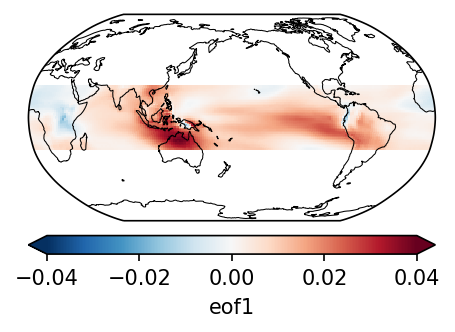

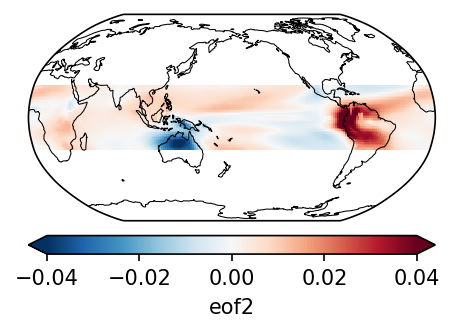

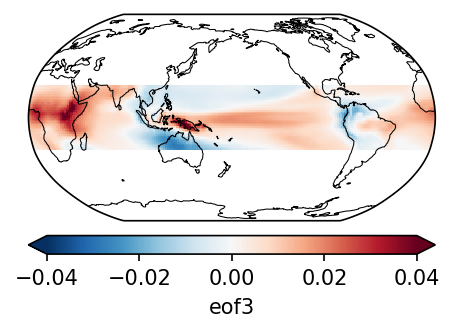

In [11]:
for i in range(0,3):
    fig = plt.figure(figsize=(3.5,2.625), dpi=150)

    ax = plt.axes(projection=ccrs.Robinson(central_longitude=180, globe=None))
    ax.set_global()
    ax.coastlines(linewidth=0.5)

    eof_cyclic, lon_plot = add_cyclic_point(des_maps[:,:,i], coord=des_maps.longitude)   

    plt.pcolormesh(lon_plot,des_maps.latitude,eof_cyclic, cmap='RdBu_r',transform=ccrs.PlateCarree(central_longitude=0), vmin=-0.04, vmax=0.04)
    plt.colorbar(label = 'eof'+str(i+1),orientation='horizontal',pad=0.05,extend='both')
#     plt.savefig('eof' + str(i))

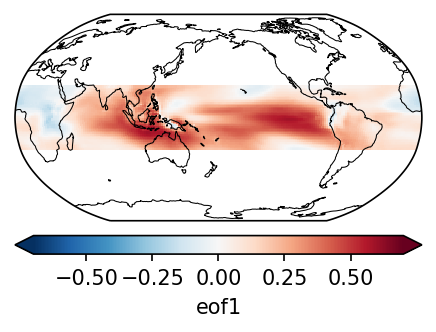

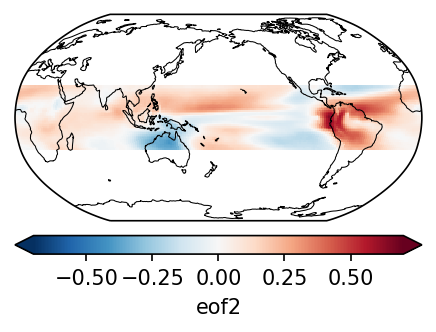

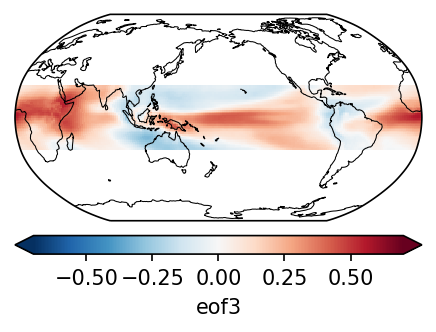

In [13]:
for i in range(0,3):
    fig = plt.figure(figsize=(3.5,2.625), dpi=150)

    ax = plt.axes(projection=ccrs.Robinson(central_longitude=180, globe=None))
    ax.set_global()
    ax.coastlines(linewidth=0.5)

    eof_cyclic, lon_plot = add_cyclic_point(des_correl[:,:,i], coord=des_correl.longitude)   

    plt.pcolormesh(lon_plot,des_correl.latitude,eof_cyclic, cmap='RdBu_r',transform=ccrs.PlateCarree(central_longitude=0), vmin=-0.7, vmax=0.7)
    plt.colorbar(label = 'eof'+str(i+1),orientation='horizontal',pad=0.05,extend='both')
#     plt.savefig('eofascorrelation' + str(i))

In [14]:
# Show fractions of variance each eof is responsible for
fractions = des_eofs.explained_variance_ratio()
print('Deseasonalised fractions: ' + str(fractions.data))

Deseasonalised fractions: [0.06080614 0.04467358 0.04085967 0.03834681 0.03022693]


In [16]:
# Pearson correlation data, returns statistical as (r,p)
# used here to measure the pc correlation to the data

from scipy.stats.stats import pearsonr
stat = pearsonr(des_pcs[:,0],np.mean(oh_anom,axis=(1,2)))

print('Pearson correlation constant PC1 to input data = ' + str(stat))

Pearson correlation constant PC1 to input data = (0.7964187912657862, 0.0)


Text(0.5, 0, 'time / yr')

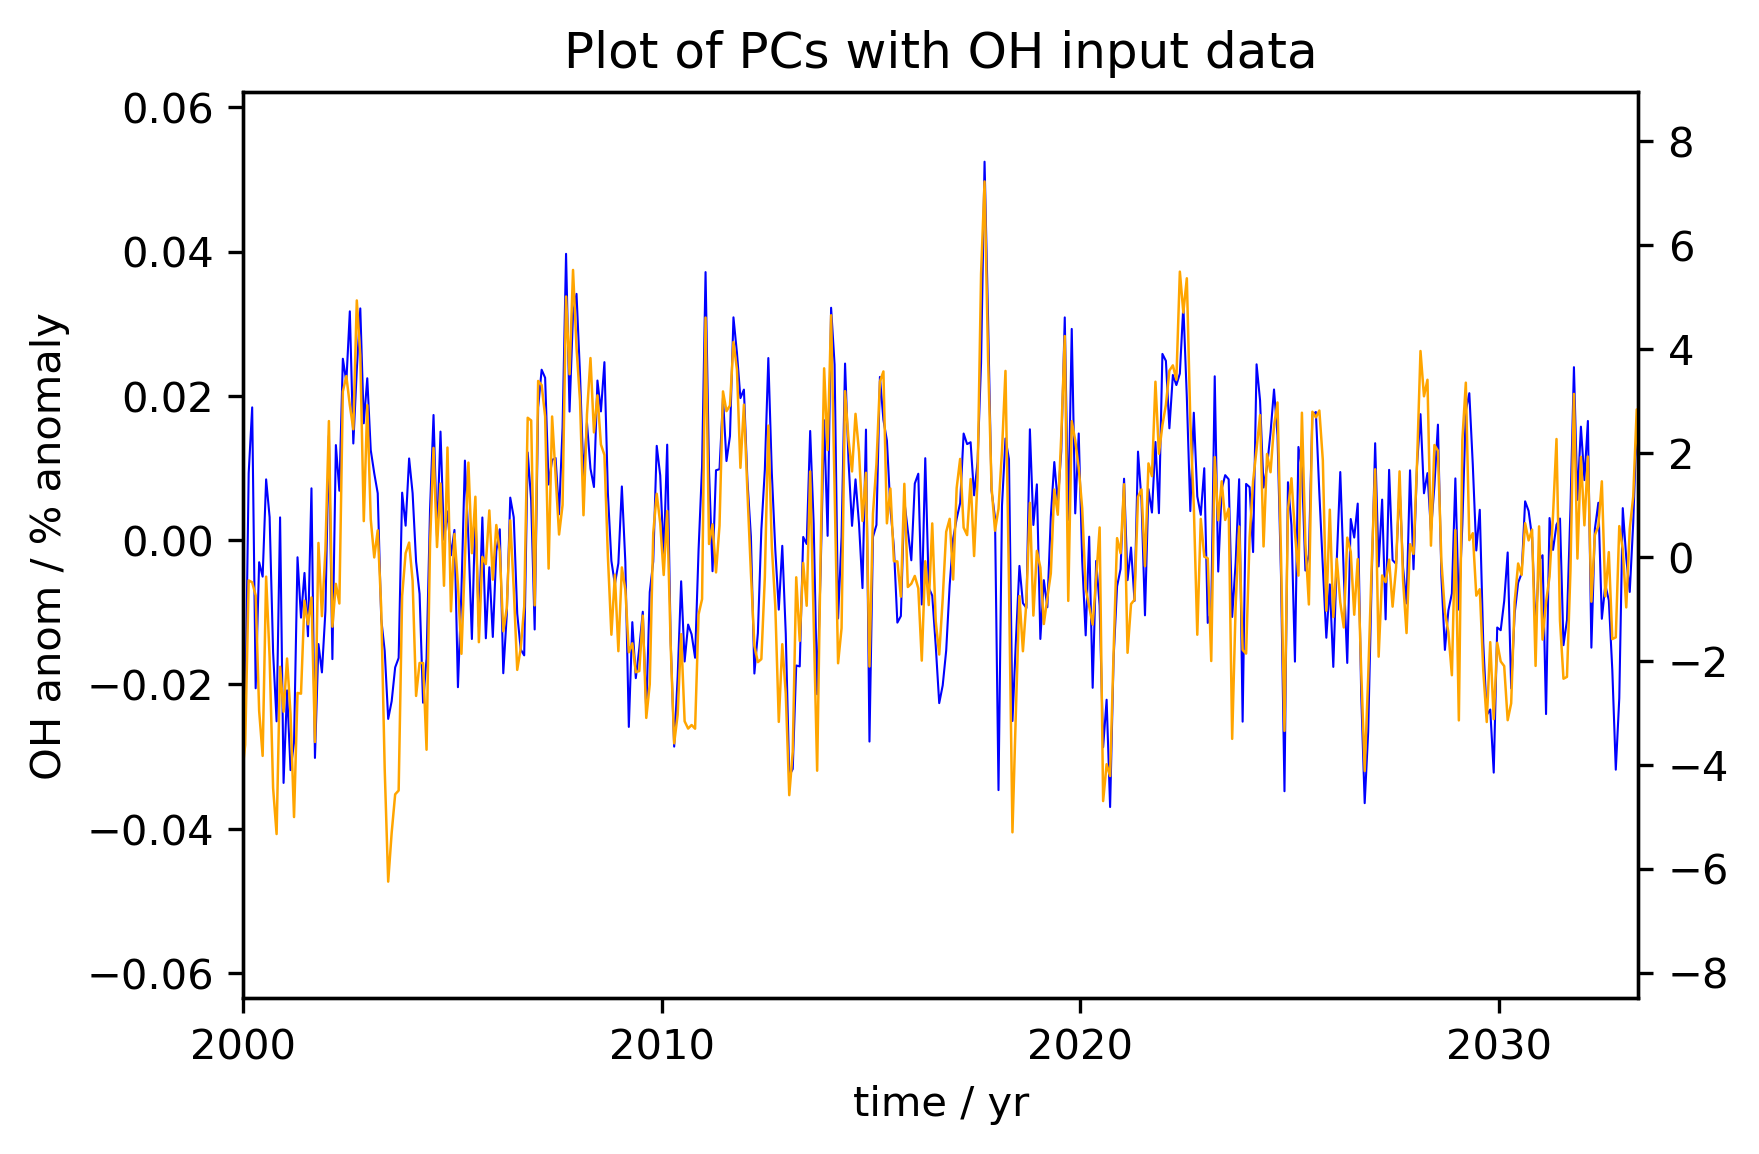

In [18]:
# Plot eofs with OH conc to compare
fig = plt.figure(dpi=300)
ax = plt.axes()

ax.plot(oh_anom.time,des_pcs[:,0],linewidth=0.5,c='blue')
# ax.plot(oh_conc.time,pcs[:,1],linewidth=0.5,c='red')
# ax.plot(oh_conc.time,pcs[:,2],linewidth=0.5,c='green')
ax1 = ax.twinx()
ax1.plot(oh_anom.time,np.mean(oh_anom,axis=(1,2)),linewidth=0.6,c='orange')

ax.set_xlim(0,12000)

plt.title('Plot of PCs with OH input data')
ax.set_ylabel('OH anom / % anomaly')
ax.set_xlabel('time / yr')

In [19]:
## Plot temperature in NINO3.4

temp_data_949 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/ubl949_temp_apm_1960_2340_PI.nc')
temp_949 = temp_data_949.surface_temperature
lat = temp_data_949.latitude
lon = temp_data_949.longitude
time_949 = temp_data_949.time

# apply nino3.4 mask to data
nino34_temp = temp_949.loc[:,-5:5,190:240]
nino_mean_949 = np.mean(nino34_temp,axis=(1,2))

# More complex way to make mask, which does preserve array size
# temp_data_949['mask'] = xr.ones_like(temp_949)
# temp_data_949['mask'] = temp_data_949.mask.where(np.abs(temp_949.latitude)<5,other=0.) 
# temp_data_949['mask'] = temp_data_949.mask.where(temp_949.longitude<240,other=0.)
# temp_data_949['mask'] = temp_data_949.mask.where(temp_949.longitude>190,other=0.)
# enso_949 = ma.masked_where(temp_data_949.mask!=1,temp_949)

## calculate rolling mean for enso data
# note doing it this way does cause some error at the edges, but does make the datasets the same length, which is convienient

bl949_3monmean = moving_average(nino_mean_949,3)
# bl949_3monmean = nino_mean_949.rolling(time=3,min_periods=1,center=True).mean()

# da.rolling(time=3, center=True).mean().dropna("time")

bl949_30yrmean = moving_average(nino_mean_949,361)
# bl949_30yrmean = nino_mean_949.rolling(time=360,min_periods=1,center=True).mean()

temp_anomaly_bl949 = bl949_3monmean[179:-179] - bl949_30yrmean

dtime_949 = nc.date2num(time_949,'days since 2000-01-01 00:00:00',calendar='360_day',has_year_zero=True)

Text(0.5, 0, 'time / yr')

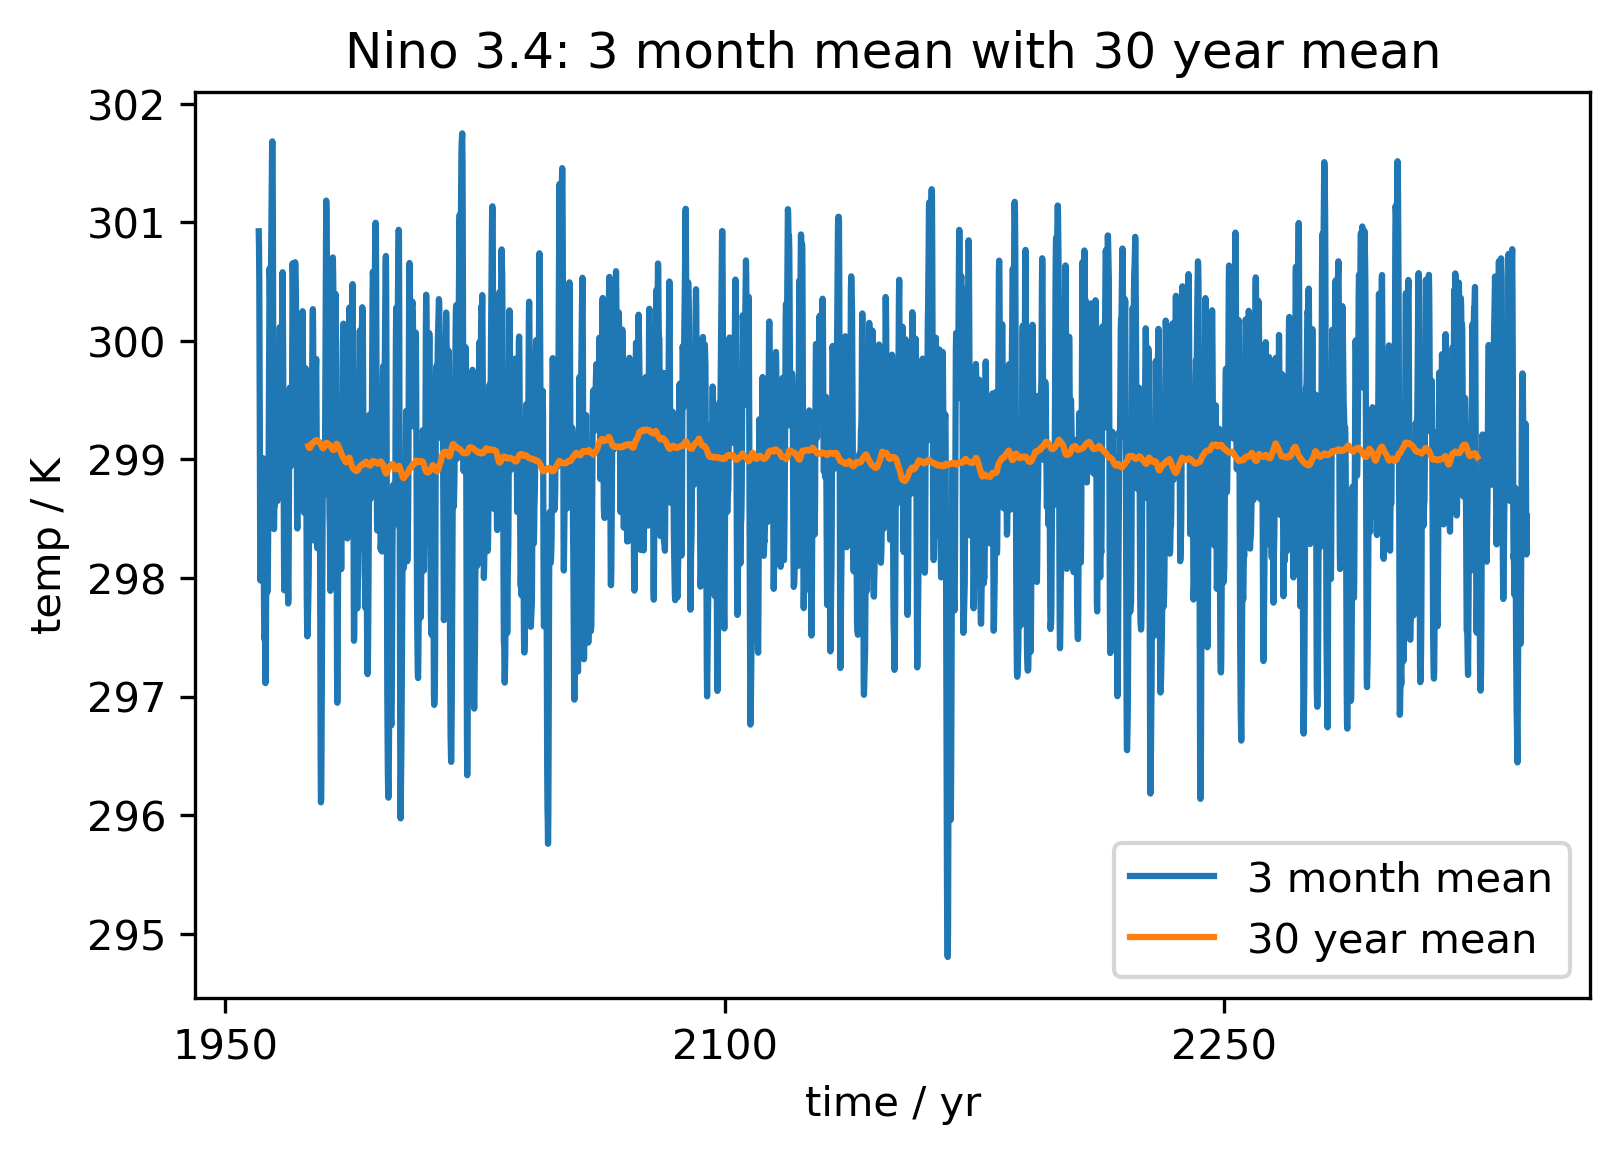

In [20]:
# Plot Nino 3.4 temperature means
fig = plt.figure(dpi=300)
ax = plt.axes()

ax.plot(time_949.time[1:-1],bl949_3monmean,label='3 month mean')
ax.plot(time_949.time[180:-180],bl949_30yrmean,label='30 year mean')

plt.legend()
plt.title('Nino 3.4: 3 month mean with 30 year mean')
ax.set_ylabel('temp / K')
ax.set_xlabel('time / yr')

Text(0.5, 1.0, 'u-bl949: PC 1 and NINO3.4 SST anomalies')

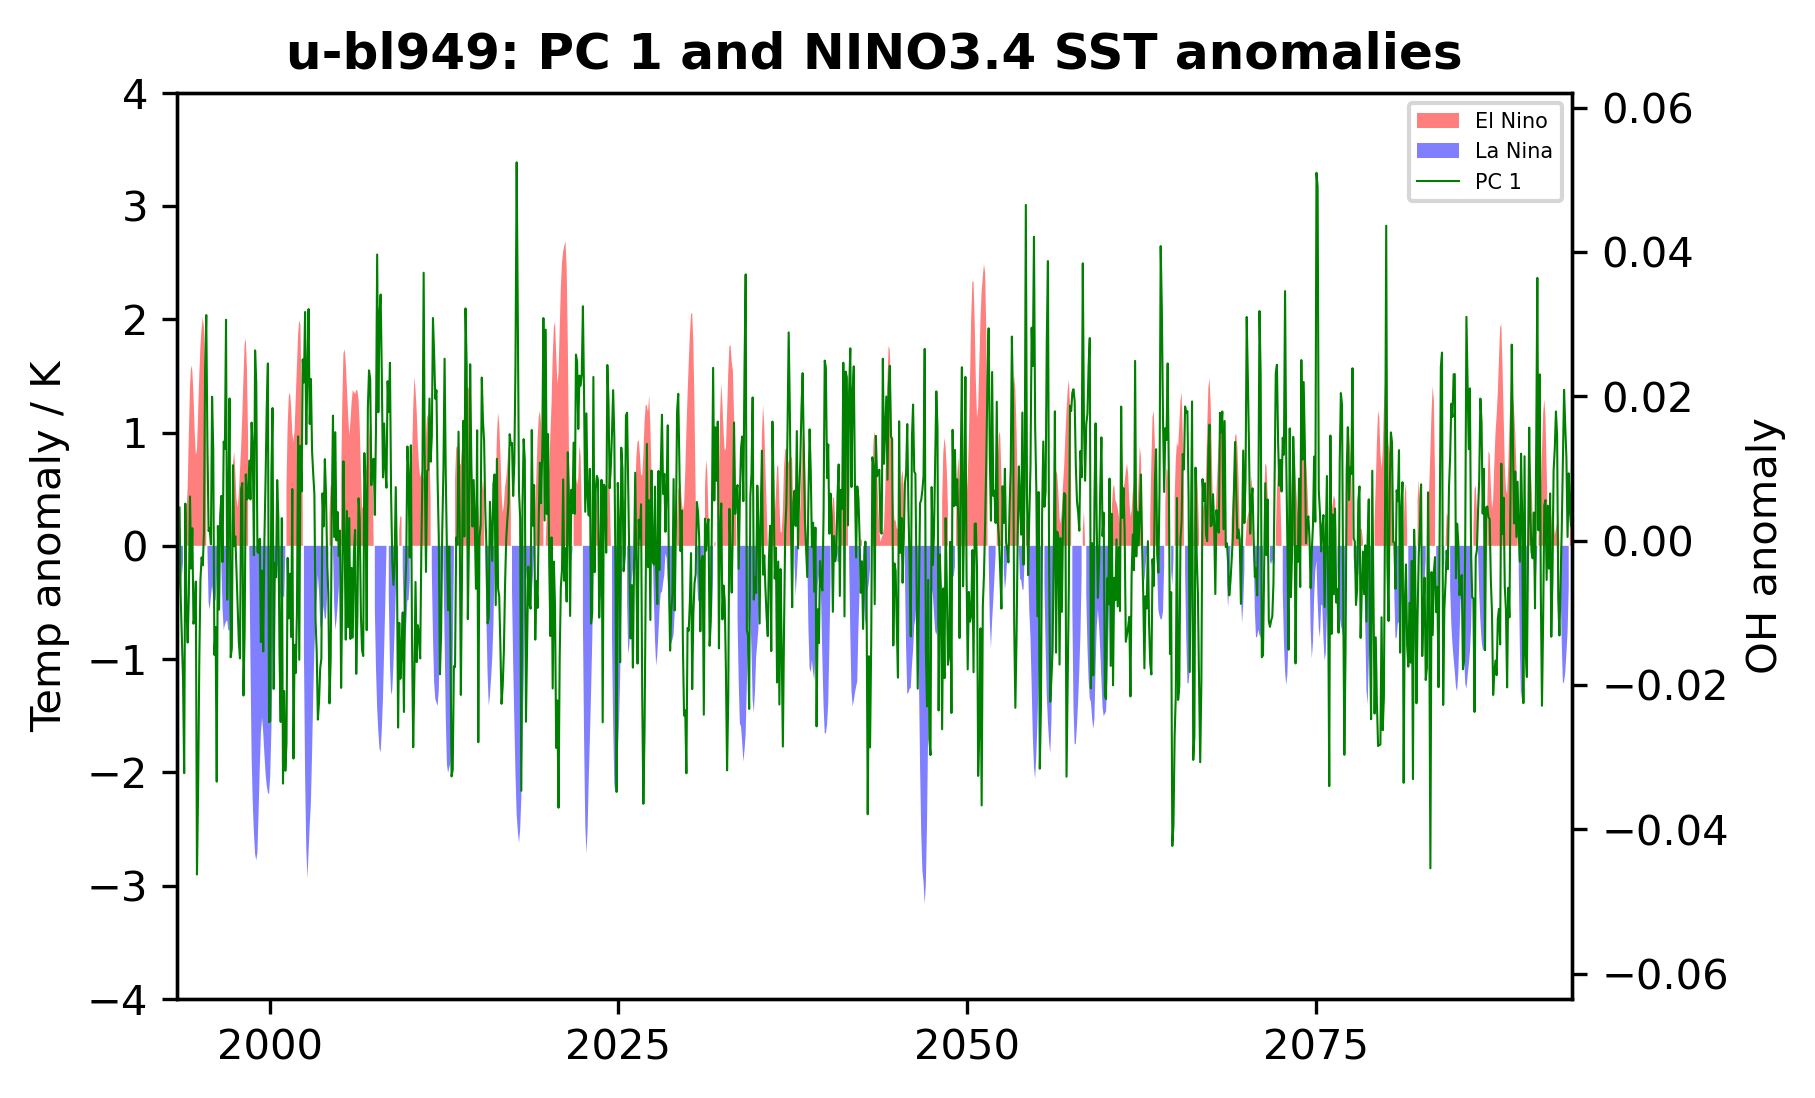

In [21]:
# Plot the nino temperature anomaly

fig = plt.figure(dpi=300)
ax = plt.axes()

ax.set_ylabel('SST anomaly / K')
#p4, = ax.plot(time_949[:925], temp_anomaly_bl949, label = 'SST anomaly', c = 'k', linewidth = 0.1)
p1 = ax.fill_between(dtime_949[180:-180], temp_anomaly_bl949, 0 ,where=(temp_anomaly_bl949 > 0), facecolor='red', alpha=0.5, label = 'El Nino')
p2 = ax.fill_between(dtime_949[180:-180], temp_anomaly_bl949, 0 ,where=(temp_anomaly_bl949 < 0), facecolor='blue', alpha=0.5, label = 'La Nina')

ax1 = ax.twinx()
ax1.set_ylabel('OH anomaly', fontsize=10)
p3, = ax1.plot(time,des_pcs[:,0], c='green', linewidth = 0.5,label='PC 1')

ax.set_ylim(-4,4)
#ax1.set_ylim(-4,4)
ax.set_xlim(dtime_949[400],dtime_949[1600])
# ax.set_xlim(0,50000)

ax.set_ylabel('Temp anomaly / K')
ax.legend(handles=[p1,p2,p3],fontsize=5,loc ='upper right')
plt.xlabel('Time')

plt.title('u-bl949: PC 1 and NINO3.4 SST anomalies',fontweight='bold')

In [23]:
from scipy.signal import savgol_filter

pc_smooth = savgol_filter(des_pcs[:,0],51,6)

temp_smooth = savgol_filter(temp_anomaly_bl949,37,6)

Text(0.5, 1.0, 'u-bl949: PC 1 and NINO3.4 SST anomalies')

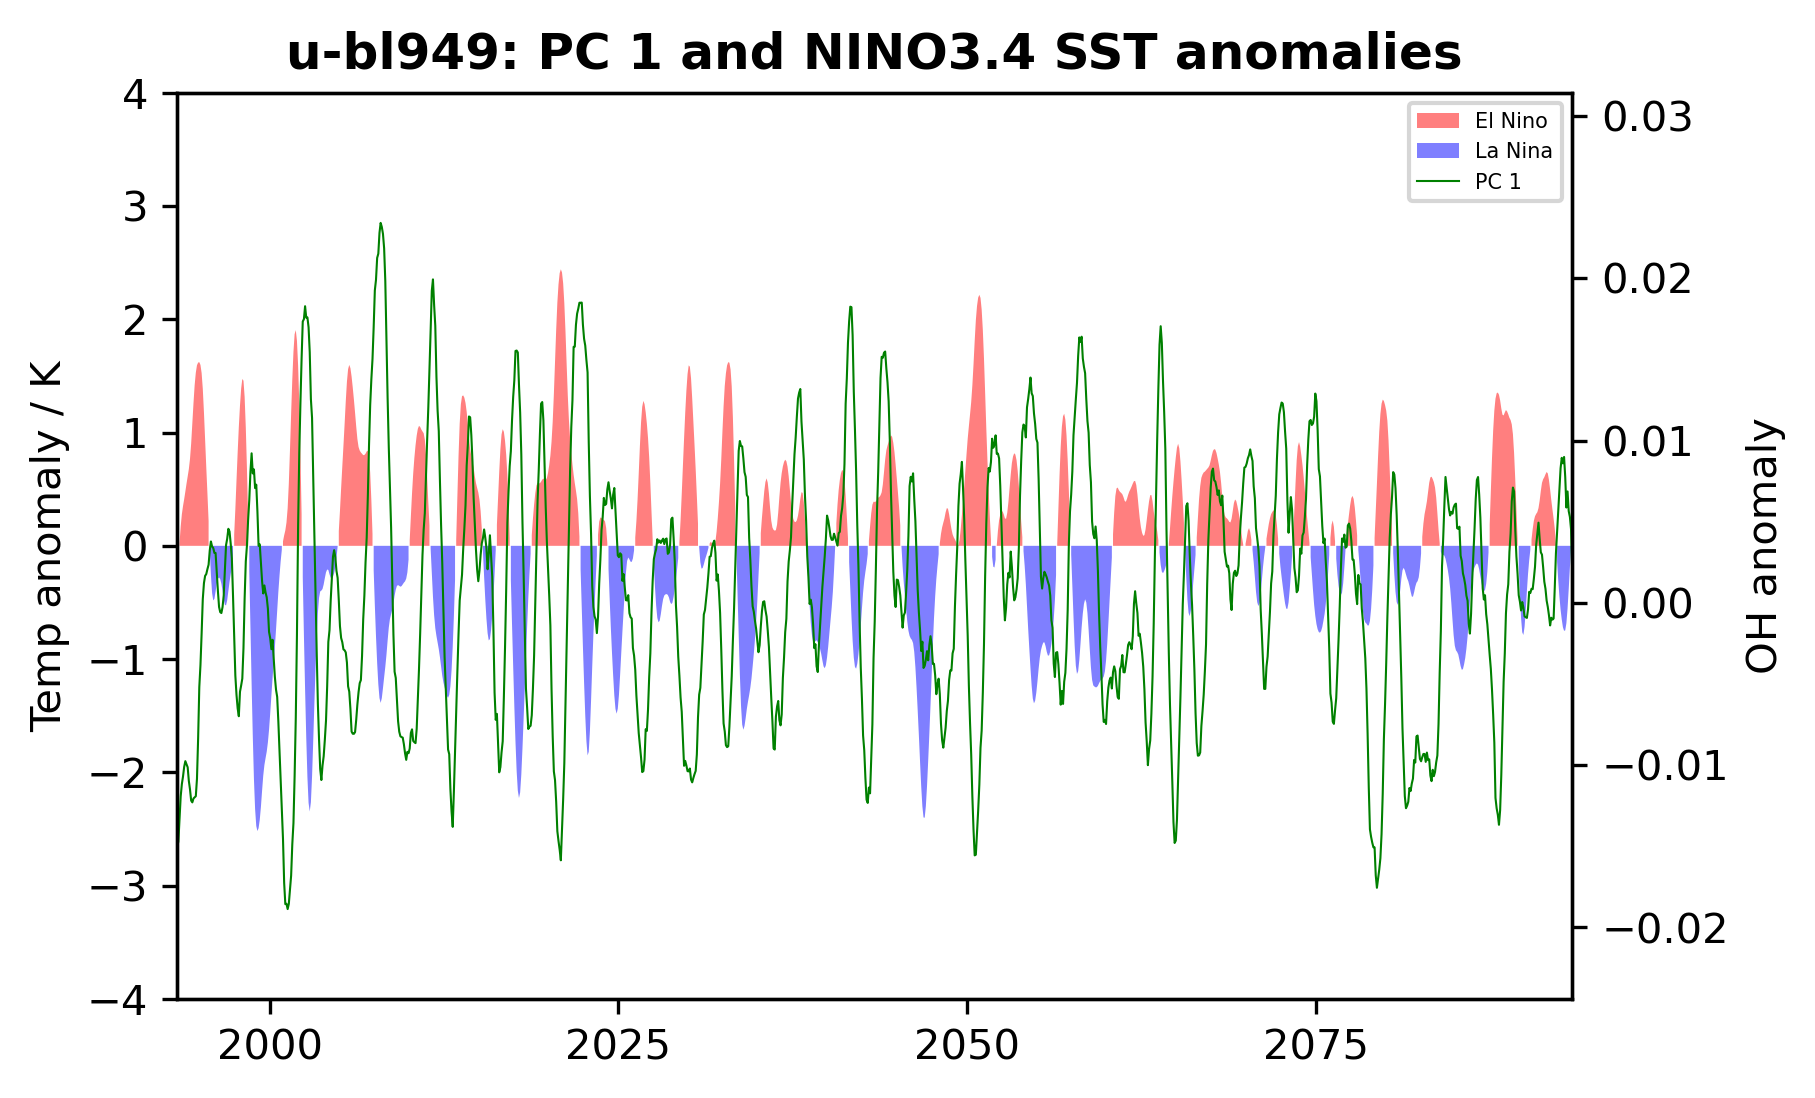

In [24]:
# Plot the nino temperature anomaly

fig = plt.figure(dpi=300)
ax = plt.axes()

ax.set_ylabel('SST anomaly / K')
#p4, = ax.plot(time_949[:925], temp_anomaly_bl949, label = 'SST anomaly', c = 'k', linewidth = 0.1)
p1 = ax.fill_between(dtime_949[180:-180], temp_smooth, 0 ,where=(temp_smooth > 0), facecolor='red', alpha=0.5, label = 'El Nino')
p2 = ax.fill_between(dtime_949[180:-180], temp_smooth, 0 ,where=(temp_smooth < 0), facecolor='blue', alpha=0.5, label = 'La Nina')

ax1 = ax.twinx()
ax1.set_ylabel('OH anomaly', fontsize=10)
p3, = ax1.plot(time,pc_smooth, c='green', linewidth = 0.5,label='PC 1')

ax.set_ylim(-4,4)
#ax1.set_ylim(-4,4)
ax.set_xlim(dtime_949[400],dtime_949[1600])
# ax.set_xlim(0,50000)

ax.set_ylabel('Temp anomaly / K')
ax.legend(handles=[p1,p2,p3],fontsize=5,loc ='upper right')
plt.xlabel('Time')

plt.title('u-bl949: PC 1 and NINO3.4 SST anomalies',fontweight='bold')

In [26]:
stat = pearsonr(des_pcs[180:-180,0],temp_anomaly_bl949)

print('Pearson correlation constant = ' + str(stat))

Pearson correlation constant = (-0.19600324375918987, 9.78207402770459e-38)


In [28]:
pearsonr(pc_smooth[180:-180],temp_smooth)

(-0.4050933570622433, 4.516861569295505e-166)

# Attempt to create rotated eofs which better represent the physical processes

Rotation of the eofs can yield different spatial patterns, and can also affect the variance fraction of each.
The xeofs package is used, which allows rotations to be applied to the functions, rotation parameters used are for a
varimax rotation and are taken from the xeofs documentation

In [29]:
# Rotate eofs to check if better solutions possible, varimax tried here

rot_eofs = xf.xarray.Rotator(des_eofs,n_rot=50,power=1)

In [30]:
rot_maps = rot_eofs.eofs()
rot_correl = rot_eofs.eofs_as_correlation()
rot_correl = rot_correl[0]
rot_pcs = rot_eofs.pcs()

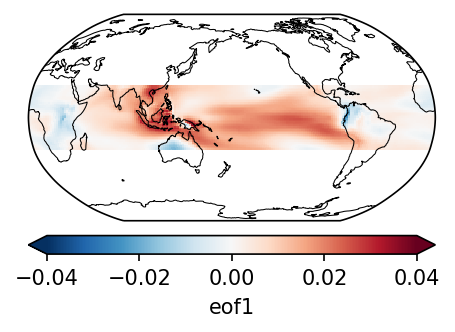

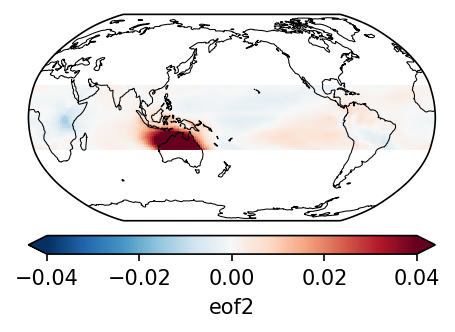

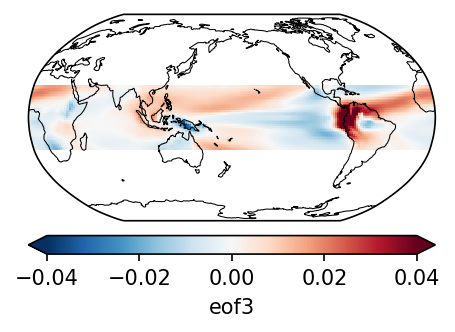

In [31]:
for i in range(0,3):
    fig = plt.figure(figsize=(3.5,2.625), dpi=150)

    ax = plt.axes(projection=ccrs.Robinson(central_longitude=180, globe=None))
    ax.set_global()
    ax.coastlines(linewidth=0.5)

    eof_cyclic, lon_plot = add_cyclic_point(rot_maps[:,:,i], coord=rot_maps.longitude)   

    plt.pcolormesh(lon_plot,rot_maps.latitude,eof_cyclic, cmap='RdBu_r',transform=ccrs.PlateCarree(central_longitude=0), vmin=-0.04, vmax=0.04)
    plt.colorbar(label = 'eof'+str(i+1),orientation='horizontal',pad=0.05,extend='both')
#     plt.savefig('eof' + str(i))

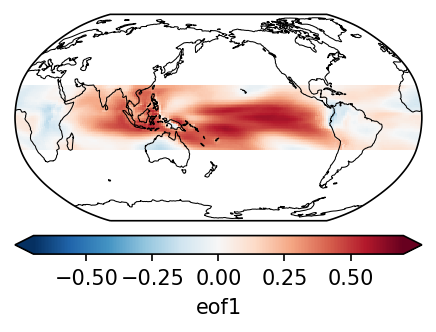

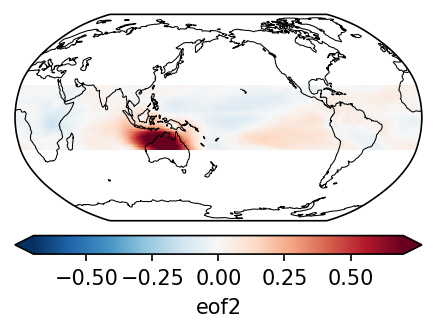

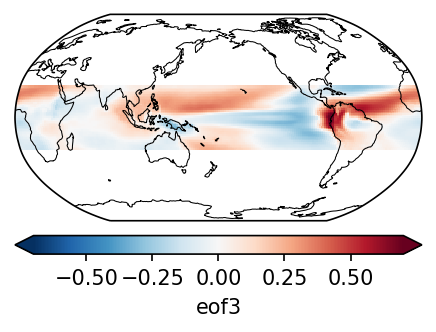

In [32]:
for i in range(0,3):
    fig = plt.figure(figsize=(3.5,2.625), dpi=150)

    ax = plt.axes(projection=ccrs.Robinson(central_longitude=180, globe=None))
    ax.set_global()
    ax.coastlines(linewidth=0.5)

    eof_cyclic, lon_plot = add_cyclic_point(rot_correl[:,:,i], coord=rot_correl.longitude)   

    plt.pcolormesh(lon_plot,rot_correl.latitude,eof_cyclic, cmap='RdBu_r',transform=ccrs.PlateCarree(central_longitude=0), vmin=-0.7, vmax=0.7)
    plt.colorbar(label = 'eof'+str(i+1),orientation='horizontal',pad=0.05,extend='both')
#     plt.savefig('eofascorrelation' + str(i))

In [33]:
# Show fractions of variance each eof is responsible for
fractions = rot_eofs.explained_variance_ratio()
print('Deseasonalised fractions: ' + str(fractions.data))

Deseasonalised fractions: [0.05110575 0.0457392  0.04024918 0.03967143 0.03814757]


Text(0.5, 1.0, 'u-bl949: PC 1 and NINO3.4 SST anomalies')

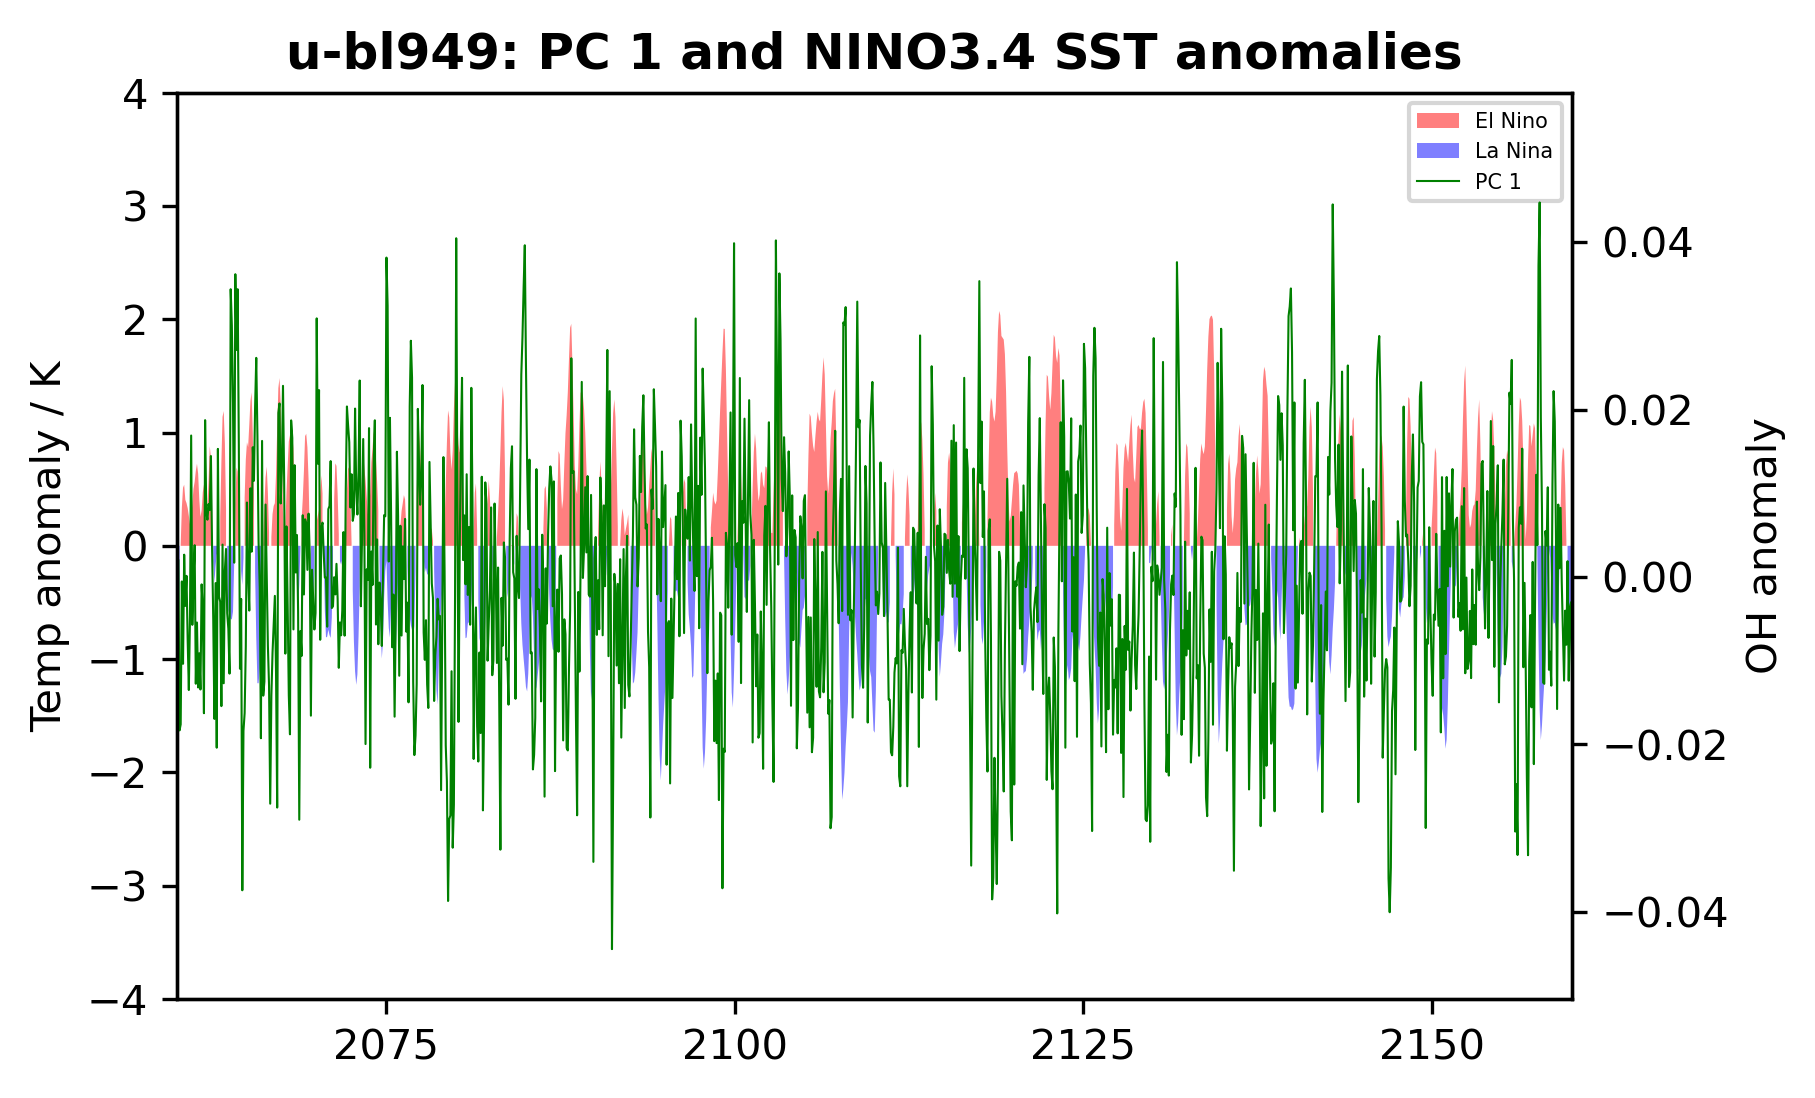

In [35]:
# Plot the nino temperature anomaly

fig = plt.figure(dpi=300)
ax = plt.axes()

ax.set_ylabel('SST anomaly / K')
#p4, = ax.plot(time_949[:925], temp_anomaly_bl949, label = 'SST anomaly', c = 'k', linewidth = 0.1)
p1 = ax.fill_between(dtime_949[180:-180], temp_anomaly_bl949, 0 ,where=(temp_anomaly_bl949 > 0), facecolor='red', alpha=0.5, label = 'El Nino')
p2 = ax.fill_between(dtime_949[180:-180], temp_anomaly_bl949, 0 ,where=(temp_anomaly_bl949 < 0), facecolor='blue', alpha=0.5, label = 'La Nina')

ax1 = ax.twinx()
ax1.set_ylabel('OH anomaly', fontsize=10)
p3, = ax1.plot(time,rot_pcs[:,0], c='green', linewidth = 0.5,label='PC 1')

ax.set_ylim(-4,4)
#ax1.set_ylim(-4,4)
ax.set_xlim(dtime_949[1200],dtime_949[2400])
# ax.set_xlim(0,50000)

ax.set_ylabel('Temp anomaly / K')
ax.legend(handles=[p1,p2,p3],fontsize=5,loc ='upper right')
plt.xlabel('Time')

plt.title('u-bl949: PC 1 and NINO3.4 SST anomalies',fontweight='bold')

In [ ]:
stat = pearsonr(rot_pcs[:,2],temp_anomaly_bl949)

print('Pearson correlation constant = ' + str(stat))